# Deep Q Learning

#### Can I take the findings from Q-Learning, and extend it to a deep learning framework?

#### Use this framework to incorporate Card Count?

In [1]:
# For some reason, importing this first doesn't crash the kernel

import torch
import torch.nn as nn

In [99]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

# Custom Modules.
from src.modules.game import Game
from src.modules.player import Player

from src.helpers.runner import select_action
from src.helpers.q_learning import gen_episode
from src.pydantic_types import StateActionPair

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Import learned Q function to be used for comparison

In [43]:
Qlearned = np.load("./models/Q.npy", allow_pickle=True).item()

# Observe distribution of Card Count in several games played.

The module automatically handles reshuffling, so I can just repeat play without re-initializing the module.

I have a "ratio penetrate" flag, which defaults to 2/3 . This means that the deck is reshuffled after it gets through 2/3rds of the deck. I default to 6 deck game as well. You can adjust these values in the Game module.

The distribution of count will be dependent on number of decks used, and ratio penetrate. Although with large ratio penetrate, the distribution might seem a bit misleading. This is because, if there is a large/small count at the point of reshuffling, we neglect the fact that if we play every card (instead of stopping short to reshuffle), the count will converge back to 0 by the end of the deck.

In [12]:
rules = {
    "dealer_hit_soft17": True,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}

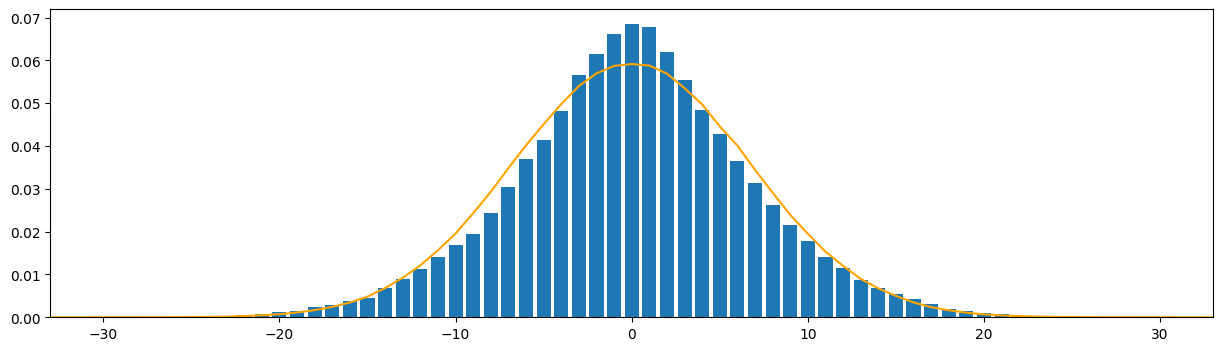

In [14]:


blackjack = Game(**game_hyperparams)
count = []

for _ in range(50000) :
    
    count.append(blackjack.count)
    
    blackjack.init_round(wagers=[1])
    blackjack.deal_init()
    player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
    house_show = blackjack.get_house_show(show_value=True)

    while not player.is_done() :

        player_show,useable_ace = player.get_value()

        policy = player.get_valid_moves()
        policy = [p for p in policy if p!='insurance']

        state = Qlearned[(player_show, house_show, useable_ace)]

        move = select_action(state, policy, -1, "epsilon")

        # Gather count after every single move.
        count.append(blackjack.count)

        blackjack.step_player(player,move)
    blackjack.step_house()
    
plt.figure(figsize=(15,4))
inds = np.argsort(pd.Series(count).value_counts(normalize=True).index.to_list())
plt.bar(
    pd.Series(count).value_counts(normalize=True).index[inds],
    pd.Series(count).value_counts(normalize=True).values[inds]
)
samples = np.random.normal(0,np.array(count).std(), 1_000_000)
minmax = max(abs(min(count)), max(count))
a, b = np.histogram(samples, np.arange(-minmax-1.5, minmax+1.5), density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])], a, color="orange")
plt.xlim(-minmax, minmax)
plt.show()

## Deep Q Learning


The Q learning without card count is found in my previous notebook. While we determine the Q function explicitly, this requires access to all state-action pairs.

In Deep Q Learning, we are ultimately approximating the Q function through use of linear + non-linear layers in a neural network, attempting to minimize MSE between predicted and actual Q values. We will ultimately be regressing the Q value for each possible action for a given state.

As proposed by Deepmind, we make use of a **target network** and a **q network**.

This is because, we are otherwise chasing a non-stationary target in the Q(s,a) values.

Given state $s$, we use the **q network** to compute the $Q(s,a)$ values for each action. At the same time, the **target network** uses the next state $s`$ to compute $Q(s`,a)$ for the TD target.

We can implement **experience replay**, where we store the agent's past experience in a list  

In [310]:
class Net(nn.Module) :
    
    def __init__(self, input_dim, output_dim, hidden_layers=[]) :
        super(Net, self).__init__()
        
        assert len(hidden_layers) , "must have at least 1 hidden layer"
        
        self.moves = ["stay", "hit", "split", "double"]

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.fc_input = nn.Linear(self.input_dim, self.hidden_layers[0])
        self.relu = nn.ReLU()
        
        self.fc_hidden = []
        for i in range(len(self.hidden_layers)-1) :
            self.fc_hidden.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
            
        self.fc_output = nn.Linear(self.hidden_layers[-1], self.output_dim)
        self.softmax = nn.Softmax(dim=0)

    def mask(self, valid_moves):

        return torch.tensor([int(move in valid_moves) for move in self.moves])

        
    def forward(self, data, valid_moves) :
        
        x = self.relu(self.fc_input(data))
        
        for layer in self.fc_hidden :
            x = self.relu(layer(x))

        x = self.fc_output(x)
        mask = self.mask(valid_moves)
        
        x = torch.tensor([x[i] if m else -torch.inf for i,m in enumerate(mask)])

        print(mask)
        print(x)

        return self.softmax(x)

In [311]:
online_net = Net(2, 4, [50,50])

In [312]:
online_net.forward(torch.tensor([1, 1], dtype=torch.float32), valid_moves=["hit", "stay"])

tensor([1, 1, 0, 0])
tensor([0.1148, 0.0667,   -inf,   -inf])


tensor([0.5120, 0.4880, 0.0000, 0.0000])

In [313]:
class EarlyStop:
    
    def __init__(self,patience=10,epsilon=1e-5) :
        
        self.allowed = 0
        self.patience = patience
        self.epsilon = epsilon
        self.early_stop = False
        self.state_dict = {}
        self.min_loss = 9e10
        
    def step(self, loss, model) :
        
        if abs(loss - self.min_loss) < self.epsilon :
            print('Incremental Loss is less than epsilon value...')
            self.early_stop = True
        if loss > self.min_loss :
            self.allowed += 1
        else :
            self.min_loss = loss
            self.state_dict = model.state_dict()
            self.allowed = 0 # reset if the loss decreased an acceptable amount
            
        if self.allowed == self.patience :
            print(f'Loss has not decreased for {self.patience} epochs')
            self.early_stop = True

In [37]:
class Trainer(EarlyStop):
    
    def __init__(self, model, loss, optimizer, use_early_stop=True):
        EarlyStop.__init__(self)
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.use_early_stop = use_early_stop      
    
    def train_epoch(self, inputs, targets, batch_size):
        
        self.model.train()
        error = 0
        size = inputs.size()[0]
        inds = np.random.permutation(size)
        
        for i in range(int(size/batch_size)):
            
            self.optimizer.zero_grad()
            
            outputs = self.model.forward(inputs[inds[i*batch_size:(i+1)*batch_size]])
            loss = self.loss(outputs, targets[inds[i*batch_size:(i+1)*batch_size]])
            
            loss.backward()
            self.optimizer.step()
            
            error += loss.item()
            
        if self.use_early_stop:
            self.step(error * batch_size / size, self.model)
            
        return error * batch_size / size
        
    def score(self, inputs, targets):
        
        self.model.eval()
        
        outputs = self.model.forward(inputs)
        loss = self.loss(outputs, targets)
        
        return loss.item()
    

    def copy_to_model(self, model):
        model.load_state_dict(self.model.state_dict())

In [38]:
online_net = Net(1, 4, [50,50])

In [42]:
online_net.mask(["hit", "stay", "double"])

tensor([1., 1., nan, 1.])

In [40]:
online_net.forward(torch.tensor([1, 1]), valid_moves=["hit", "stay"])

['hit', 'stay']


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 1x50)

In [190]:
BUFFER_SIZE = 10_000
GAMMA = 0.95
LR = 0.001
MIN_REPLAY_SIZE = 5_000 # this won't be hit exactly due to splitting.
TARGET_UPDATE_FREQ = 5_000
EVAL_EVERY = 5_000

online_net = Net(1, 5, [50,50])
target_net = Net(1, 5, [50,50])
target_net.load_state_dict(online_net.state_dict())

<All keys matched successfully>

In [191]:
replay_buffer = deque(maxlen=BUFFER_SIZE)
blackjack = Game(**game_hyperparams)

for _ in range(MIN_REPLAY_SIZE):
    blackjack.init_round([1])
    blackjack.deal_init()

    player = blackjack.players[0]

    s_a, action_space = gen_episode(
        blackjack=blackjack,
        player=player,
        q=Qlearned,
        epsilon=1,
        method="epsilon"
    )

    blackjack.step_house()

    _, reward_hands = player.get_result(blackjack.house.cards[0])

    for i,s_a_pair_hand in enumerate(s_a):
        for j,s_a_pair in enumerate(s_a_pair_hand[::-1]):

            state_obs = (s_a_pair.player_show, s_a_pair.house_show, int(s_a_pair.useable_ace))
            actions = [a for a in action_space[i][-j] if a != "surrender"]
            move = s_a_pair.move
            reward = 0
            done = 0

            if j==0:
                reward = reward_hands[i]
                state_obs_new = None
                done = 1
            else:
                rewind = s_a_pair_hand[::-1][1-j]
                state_obs_new = (rewind.player_show, rewind.house_show, int(rewind.useable_ace))
            
            replay_buffer.append(
                (state_obs, actions, move, reward, done, state_obs_new)
            )
    



In [192]:
replay_buffer

deque([((18, 8, 0), ['stay', 'hit', 'double'], 'hit', -1, 1, None),
       ((16, 8, 0), ['stay', 'hit'], 'hit', 0, 0, (18, 8, 0)),
       ((19, 8, 0), ['stay', 'hit', 'double'], 'hit', -1, 1, None),
       ((5, 10, 0), ['stay', 'hit', 'double'], 'double', -2, 1, None),
       ((15, 5, 0), ['stay', 'hit', 'double'], 'hit', -1, 1, None),
       ((16, 11, 0), ['stay', 'hit', 'double'], 'hit', -1, 1, None),
       ((12, 11, 0), ['stay', 'hit'], 'hit', 0, 0, (16, 11, 0)),
       ((21, 10, 0), ['stay', 'hit', 'double'], 'stay', 1, 1, None),
       ((20, 10, 0), ['stay'], 'hit', 0, 0, (21, 10, 0)),
       ((21, 6, 0), ['stay', 'hit', 'double'], 'stay', 1, 1, None),
       ((20, 6, 0), ['stay'], 'hit', 0, 0, (21, 6, 0)),
       ((19, 10, 0), ['stay', 'hit', 'double'], 'double', -2, 1, None),
       ((21, 2, 0), ['stay', 'hit', 'double'], 'stay', 1, 1, None),
       ((14, 2, 0), ['stay'], 'hit', 0, 0, (21, 2, 0)),
       ((17, 5, 0), ['stay', 'hit', 'double'], 'double', -2, 1, None),
       ((1

In [110]:
s_a

[[StateActionPair(player_show=17, house_show=7, useable_ace=False, move='double')]]

In [111]:
action_space

[[['stay', 'hit', 'surrender', 'double']]]

In [18]:
input_dim = 1

net = Net(input_dim,5,[50, 50])

loss_fct = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

trainer = Trainer(net, loss_fct, optimizer, True)